<a href="https://colab.research.google.com/github/Ryansyaaw/Machine-Learning_2023/blob/main/week%2010/week10.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import library

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

tfds.disable_progress_bar()



In [2]:
def plot_graphs(history, metric):
	plt.plot(history.history[metric])
	plt.plot(history.history['val_'+metric], '')
	plt.xlabel("Epochs")
	plt.ylabel(metric)
	plt.legend([metric, 'val_'+metric])

download dataset

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


acak data untuk pelatihan dan membuat kumpulan pasangan

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'It sounds as if it should be a biography of Claude Monet but it\'s actually a highly focused story of relationships between three adolescent girls on a French synchronized swimming team. There are no parents or teachers to speak of, no school, and boys are represented by one peripheral figure, the hunky Francois who enters the story determined from time to time and always leaves confused.<br /><br />Pauline Aquart is the youngest of the three, only aspiring to join the team she so much admires. She\'s kind of odd looking. She\'s not yet out of her adolescent growth spurt and has long, bony limbs, big feet, and no derriere to speak of. She\'s prognathous and sports these plump pursed lips. After a while her appearance grows on you and from certain angles she can come to appear enthralling.<br /><br />Adele Haenel is older -- more, well, more developed physically. What a glamorous figure she cuts in her swim suit, sauntering around, teasing the boys, swishing her long blond ha

**Buat Teks Encoder**

Membuat lapisan TextVectorization

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [7]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [8]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[  9, 919,  15, ...,   0,   0,   0],
       [  2, 422, 139, ...,   0,   0,   0],
       [  2, 802,   7, ...,   0,   0,   0]])

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'It sounds as if it should be a biography of Claude Monet but it\'s actually a highly focused story of relationships between three adolescent girls on a French synchronized swimming team. There are no parents or teachers to speak of, no school, and boys are represented by one peripheral figure, the hunky Francois who enters the story determined from time to time and always leaves confused.<br /><br />Pauline Aquart is the youngest of the three, only aspiring to join the team she so much admires. She\'s kind of odd looking. She\'s not yet out of her adolescent growth spurt and has long, bony limbs, big feet, and no derriere to speak of. She\'s prognathous and sports these plump pursed lips. After a while her appearance grows on you and from certain angles she can come to appear enthralling.<br /><br />Adele Haenel is older -- more, well, more developed physically. What a glamorous figure she cuts in her swim suit, sauntering around, teasing the boys, swishing her long blond 

**Buat Model**

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[-0.00907128]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 86ms/step
[-0.00907127]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**Train Model**

In [15]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 59s 126ms/step - loss: 0.6165 - accuracy: 0.5965 - val_loss: 0.4364 - val_accuracy: 0.7891
Epoch 2/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3920 - accuracy: 0.8255 - val_loss: 0.3847 - val_accuracy: 0.8396
Epoch 3/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3489 - accuracy: 0.8490 - val_loss: 0.3451 - val_accuracy: 0.8484
Epoch 4/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3203 - accuracy: 0.8631 - val_loss: 0.3334 - val_accuracy: 0.8536
Epoch 5/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3117 - accuracy: 0.8690 - val_loss: 0.3433 - val_accuracy: 0.8380
Epoch 6/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3053 - accuracy: 0.8700 - val_loss: 0.3366 - val_accuracy: 0.8547
Epoch 7/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3031 - accuracy: 0.8702 - val_loss: 0.3262 - val_accuracy

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 17s 42ms/step - loss: 0.3213 - accuracy: 0.8620
Test Loss: 0.3212951421737671
Test Accuracy: 0.8620399832725525


(0.0, 0.6326359257102012)

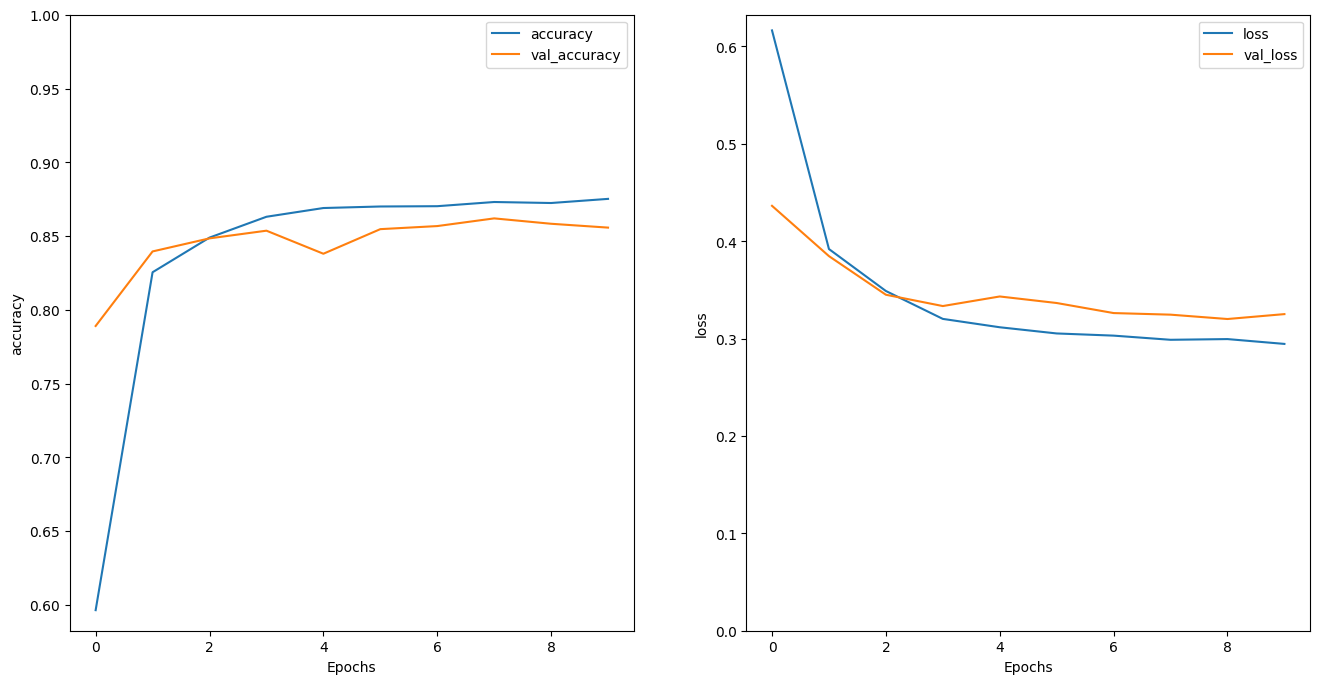

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [19]:
sample_text = ('The movie was cool. The animation and the graphics ''were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 4s 4s/step


**Stack two or more LSTM layers**

In [21]:
model = tf.keras.Sequential([encoder,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True), tf.keras.layers.Bidirectional(tf.keras.layers.LSTM (64, return_sequences=True)),tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),tf.keras.layers.Dense(64, activation='relu'),tf.keras.layers.Dropout(0.5), tf.keras.layers.Dense(1)
])

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs=10,validation_data=test_dataset,validation_steps=30)

Epoch 1/10
391/391 [==============================] - 83s 163ms/step - loss: 0.6629 - accuracy: 0.5325 - val_loss: 0.5414 - val_accuracy: 0.7448
Epoch 2/10
391/391 [==============================] - 49s 124ms/step - loss: 0.4426 - accuracy: 0.7874 - val_loss: 0.3916 - val_accuracy: 0.8099
Epoch 3/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3647 - accuracy: 0.8383 - val_loss: 0.3523 - val_accuracy: 0.8354
Epoch 4/10
391/391 [==============================] - 46s 116ms/step - loss: 0.3406 - accuracy: 0.8516 - val_loss: 0.3393 - val_accuracy: 0.8417
Epoch 5/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3241 - accuracy: 0.8616 - val_loss: 0.3328 - val_accuracy: 0.8510
Epoch 6/10
391/391 [==============================] - 50s 128ms/step - loss: 0.3171 - accuracy: 0.8640 - val_loss: 0.3273 - val_accuracy: 0.8583
Epoch 7/10
391/391 [==============================] - 52s 133ms/step - loss: 0.3119 - accuracy: 0.8668 - val_loss: 0.3282 - val_ac

In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 24s 61ms/step - loss: 0.3199 - accuracy: 0.8546
Test Loss: 0.3198760151863098
Test Accuracy: 0.8545600175857544


In [25]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics ''were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 7s 7s/step
[[-1.7357529]]


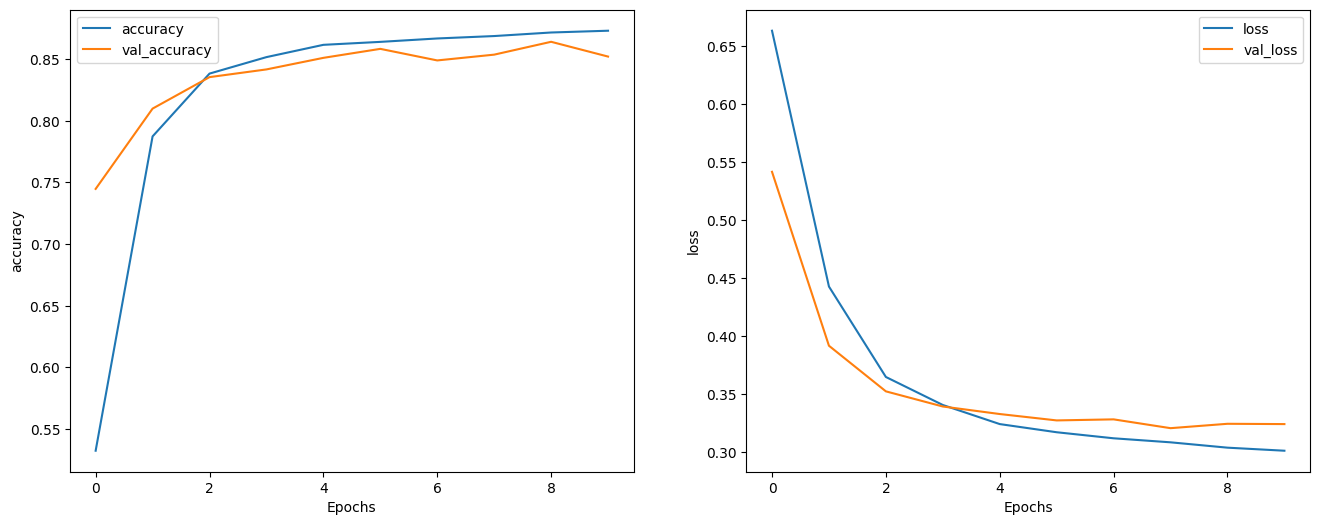

In [26]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')